In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import pandas_profiling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
trans = pd.read_csv('/Users/mindurumi/Downloads/ieee-fraud-detection/train_transaction.csv', index_col='TransactionID')
test_trans = pd.read_csv('/Users/mindurumi/Downloads/ieee-fraud-detection/test_transaction.csv', index_col='TransactionID')

In [4]:
ident = pd.read_csv('/Users/mindurumi/Downloads/ieee-fraud-detection/train_identity.csv', index_col='TransactionID')
test_ident = pd.read_csv('/Users/mindurumi/Downloads/ieee-fraud-detection/test_identity.csv', index_col='TransactionID')

In [9]:
sample_sub = pd.read_csv('/Users/mindurumi/Downloads/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')

In [11]:
sample_sub.shape

(506691, 1)

In [12]:
train = trans.merge(ident, how='left', left_index=True, right_index=True)
test = test_trans.merge(test_ident, how='left', left_index=True, right_index=True)

In [13]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[: 3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min  and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum()/ 1024**2
    print('Memory usage after optimization is: {:.2f} MB, {:.1f}% reduction'.\
          format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [14]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)


Memory usage after optimization is: 668.22 MB, 66.2% reduction
Memory usage after optimization is: 583.43 MB, 65.6% reduction


In [15]:
isna = train.isna().sum(axis=1)
isna_test = test.isna().sum(axis=1)

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


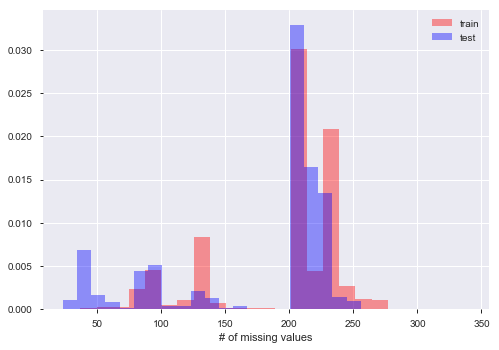

In [25]:
plt.hist(isna, normed=True, bins=25, alpha=0.4, label='train', color='r')
plt.hist(isna_test, normed=True, bins=25, alpha=0.4, label='test', color='b')
plt.xlabel('# of missing values')
plt.legend()

Text(0.5, 1.0, 'TransactionAmt Distribution')

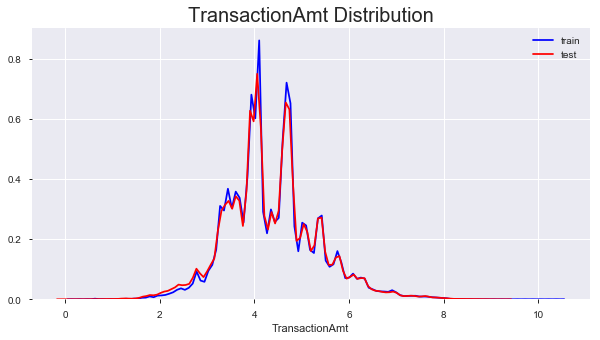

In [34]:
f, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.distplot(train['TransactionAmt'], bins=3, hist=False, ax=ax1,label='train',color='b')
ax = sns.distplot(test['TransactionAmt'], bins=3, hist=False, ax=ax1, label='test',color='r')
ax1.set_title('TransactionAmt Distribution', fontsize=20)

In [33]:
train['TransactionAmt'] = np.log(train['TransactionAmt']+1)
test['TransactionAmt'] = np.log(test['TransactionAmt']+1)

Text(0.5, 1.0, 'TransactionAmt Distribution after Log Transformation')

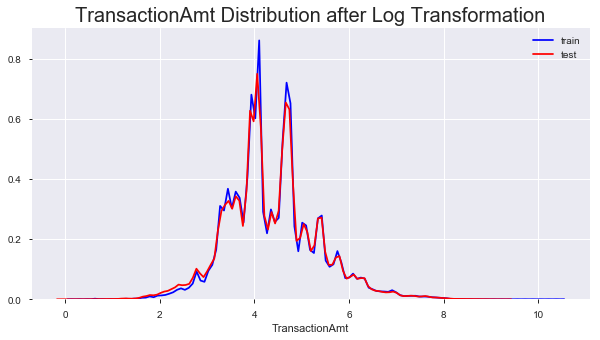

In [36]:
f, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.distplot(train['TransactionAmt'], bins=2, hist=False, ax=ax1, label='train',color='b')
ax = sns.distplot(test['TransactionAmt'], bins=2, hist=False, ax=ax1, label='test',color='r')
ax1.set_title('TransactionAmt Distribution after Log Transformation', fontsize=20)

In [44]:
transaction_data_columns = train.columns
numericCols = train._get_numeric_data().columns
categoricalCols = list(set(transaction_data_columns) - set(numericCols))
print('The categorical columns in transaction data are: ',categoricalCols)
train[categoricalCols] = train[categoricalCols].replace({ np.nan:'missing'})
train[numericCols] = train[numericCols].replace({ np.nan:-1})

The categorical columns in transaction data are:  ['id_15', 'id_33', 'M7', 'id_23', 'id_27', 'R_emaildomain', 'M8', 'id_34', 'M5', 'id_38', 'ProductCD', 'M6', 'M4', 'id_35', 'M2', 'card4', 'DeviceInfo', 'M9', 'id_31', 'M1', 'id_12', 'id_30', 'P_emaildomain', 'DeviceType', 'M3', 'id_36', 'card6', 'id_37', 'id_29', 'id_16', 'id_28']


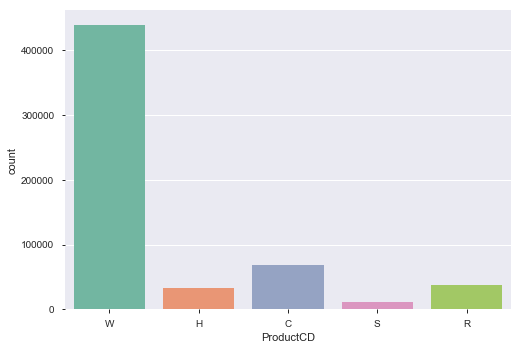

In [58]:
sns.countplot(train['ProductCD'],palette='Set2')
plt.show()

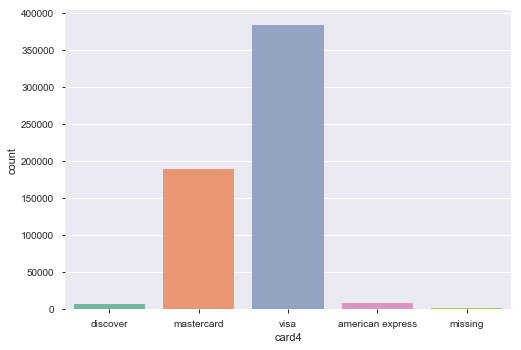

In [57]:
sns.countplot(train['card4'],palette='Set2')
plt.show()

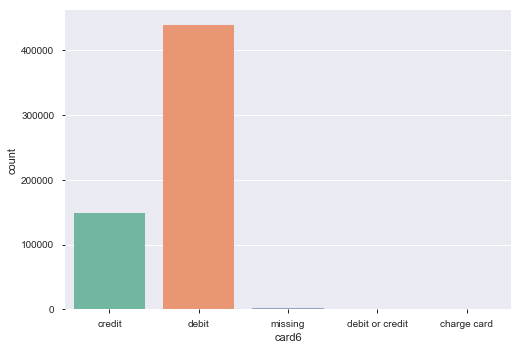

In [60]:
sns.countplot(train['card6'],palette='Set2')
plt.show()

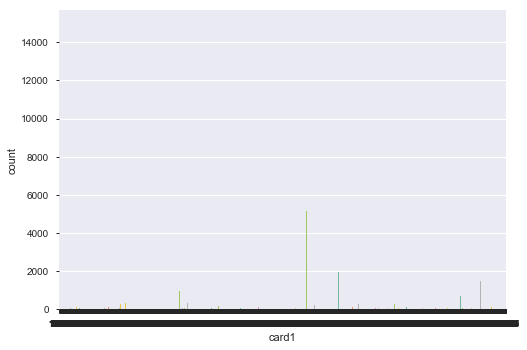

In [85]:
sns.countplot(train['card1'],palette='Set2')
plt.show()

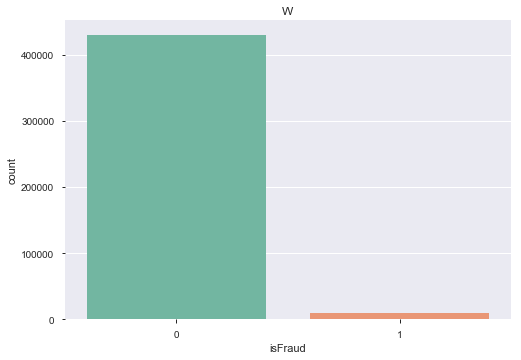

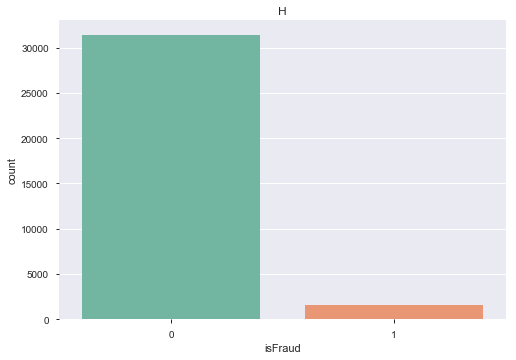

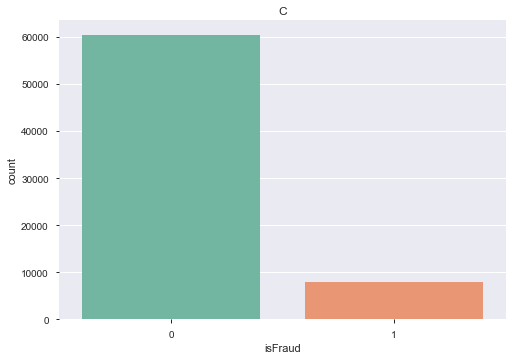

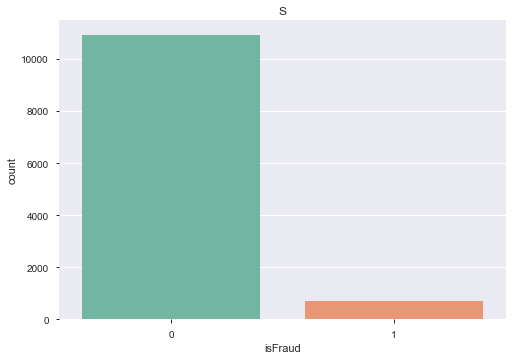

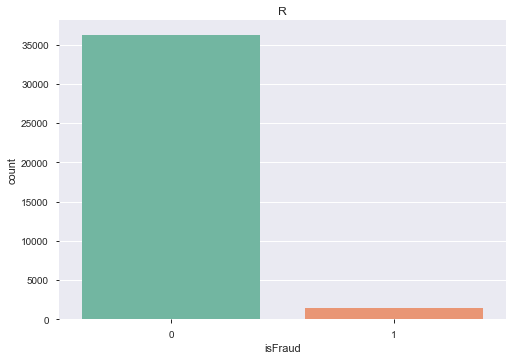

In [63]:
CDTypes = ['W','H','C','S','R']
for i,i_CD in enumerate(CDTypes):
    CDData = eval('train.loc[train["ProductCD"]=="'+i_CD+'"]')
    plt.figure(i)
    sns.countplot(CDData['isFraud'], palette='Set2').set_title(i_CD)

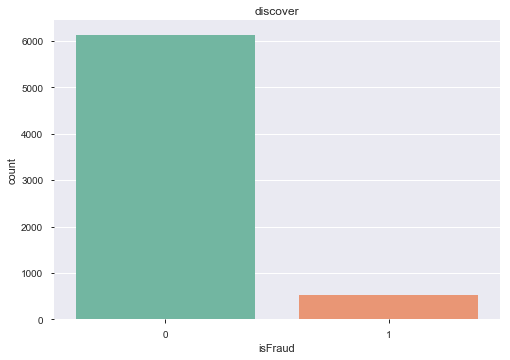

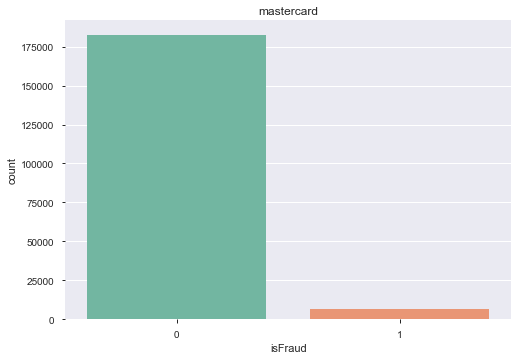

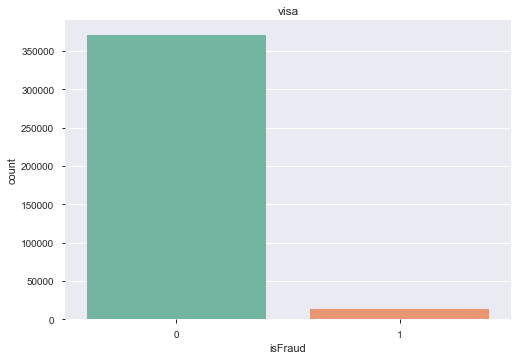

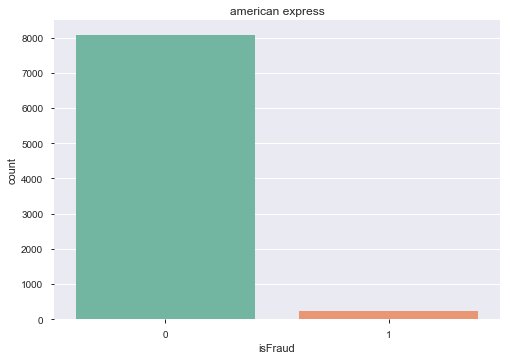

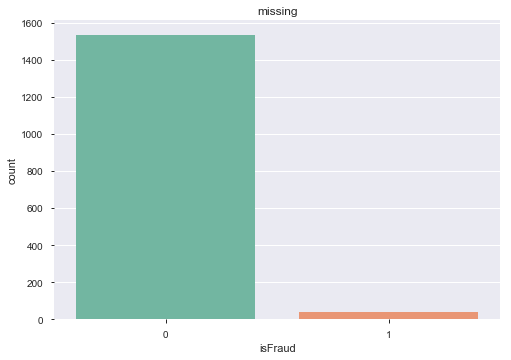

In [64]:
cardTypes = ['discover','mastercard','visa','american express','missing']
for i,i_card in enumerate(cardTypes):
    cardData = eval('train.loc[train["card4"]=="'+i_card+'"]')
    plt.figure(i)
    sns.countplot(cardData['isFraud'], palette='Set2').set_title(i_card)

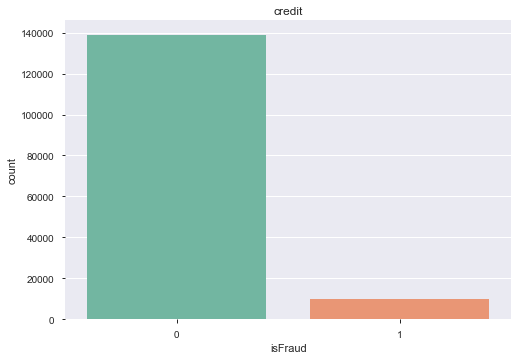

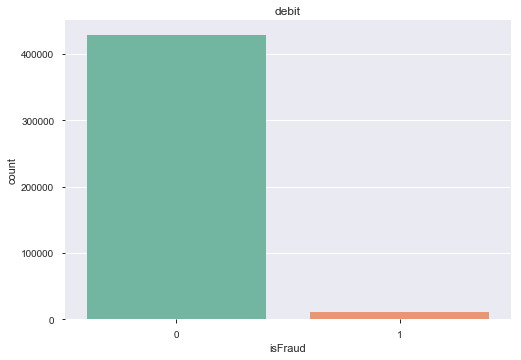

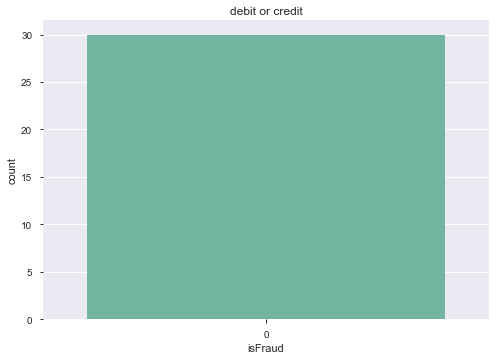

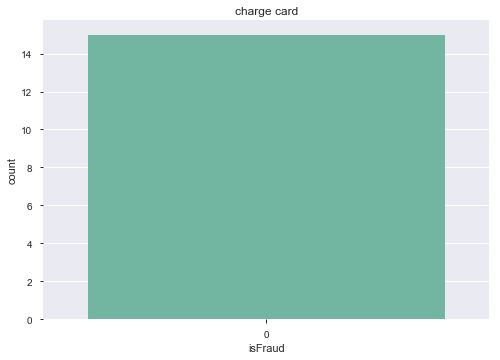

In [65]:
cardTypess = ['credit','debit','debit or credit','charge card']
for i,i_card in enumerate(cardTypess):
    cardData = eval('train.loc[train["card6"]=="'+i_card+'"]')
    plt.figure(i)
    sns.countplot(cardData['isFraud'], palette='Set2').set_title(i_card)

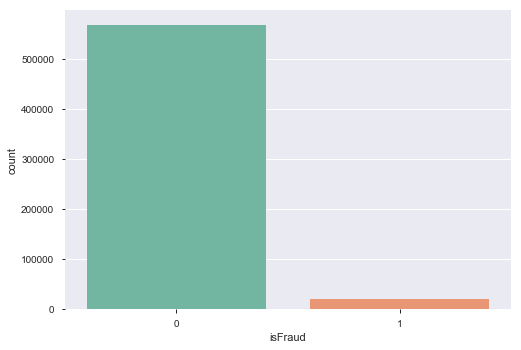

In [76]:
sns.countplot(train['isFraud'],palette='Set2')
plt.show()

In [86]:
count(train.loc[train['isFraud']==1])/len(train.shape[0])

NameError: name 'count' is not defined

In [68]:
import pandas_profiling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [73]:
!pip3 install lightgbm

  Using cached https://files.pythonhosted.org/packages/9c/b3/7b6aec53a8cd0a1378279d9f06e647298f0c66299bce0e4b2b919f6557f7/lightgbm-2.2.3-py2.py3-none-macosx_10_8_x86_64.macosx_10_9_x86_64.macosx_10_10_x86_64.macosx_10_11_x86_64.macosx_10_12_x86_64.macosx_10_13_x86_64.macosx_10_14_x86_64.whl
    100% |████████████████████████████████| 10.5MB 362kB/s ta 0:00:01
    100% |████████████████████████████████| 15.0MB 309kB/s ta 0:00:01
    100% |████████████████████████████████| 27.7MB 372kB/s ta 0:00:011   21% |██████▉                         | 5.9MB 413kB/s eta 0:00:53
    100% |████████████████████████████████| 286kB 754kB/s ta 0:00:01
You are using pip version 19.0.3, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [75]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import multiprocessing
import gc

OSError: dlopen(/anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found